# 🌾 Tutorial Overview — AI in Soil Spectroscopy
Welcome to the *AI in Agriculture* hands-on module!  
In this tutorial, you’ll learn how to use **machine learning** to predict **Soil Organic Carbon (SOC)** from soil spectral data.

---

## 🎯 Objectives
By the end of this exercise you will:
1. Understand how soil spectra represent soil composition.  
2. Visualize raw and preprocessed spectra.  
3. Apply basic preprocessing (SNV + Savitzky–Golay).  
4. Build a simple **Partial Least Squares Regression (PLSR)** model.  
5. Evaluate predictions and interpret results.

---

## 📁 Dataset Description
File: `soil_spectra_teaching.csv`  
Each row is a soil sample.

| Type | Columns | Description |
|------|----------|-------------|
| Spectral | `wl_400 ... wl_2500` | Reflectance at each wavelength (nm) |
| Target | `SOC` | Soil Organic Carbon (%) |
| Optional | `pH`, `Clay`, etc. | Other soil properties |

---



In [16]:
# 🔧 Load packages and dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = Path("MIR_scans_for_neo_outlier.csv")
df = pd.read_csv(DATA_PATH)
df.head()


,smp_id,ph_h2o,eoc_tot_c,clay_tot_psa,599.766,601.695,603.623,605.552,607.48,609.409,...,3936.069,3937.998,3939.926,3941.855,3943.783,3945.712,3947.64,3949.569,3951.497,3953.426
0,124566.0,5.90,1.4,34.1,1.76600,1.77350,1.77950,1.78525,1.79150,1.7985,...,0.418650,0.418500,0.416825,0.414450,0.413375,0.413300,0.412550,0.412025,0.412600,0.413150
1,124573.0,4.80,2.0,19.1,1.62925,1.63725,1.64725,1.65800,1.67025,1.6845,...,0.383575,0.383775,0.382475,0.380525,0.379825,0.380025,0.379425,0.379100,0.379800,0.380550
2,124574.0,4.94,1.0,34.9,1.76025,1.76925,1.77700,1.78550,1.79575,1.8080,...,0.411900,0.411700,0.410025,0.407750,0.406800,0.406700,0.405875,0.405350,0.405900,0.406475
3,124584.0,5.77,3.4,31.8,1.75225,1.75700,1.76025,1.76275,1.76625,1.7705,...,0.425150,0.425350,0.424050,0.422150,0.421475,0.421650,0.421050,0.420625,0.421325,0.422025
4,124585.0,5.65,1.1,44.4,1.80775,1.81500,1.82275,1.83150,1.84050,1.8495,...,0.454700,0.454600,0.453000,0.450750,0.449675,0.449550,0.448675,0.448125,0.448625,0.449150


# 📊 Basic info

In [22]:

print("Samples:", df.shape[0], " | Columns:", df.shape[1])

spec_cols = [c for c in df.columns if str(c).replace('.', '', 1).isdigit()]
print("Spectral columns:", len(spec_cols))
print("Other columns:", [c for c in df.columns if c not in spec_cols])



Samples: 343  | Columns: 1744
Spectral columns: 1740
Other columns: ['smp_id', 'ph_h2o', 'eoc_tot_c', 'clay_tot_psa']


# 🌈 Plot Raw Spectra

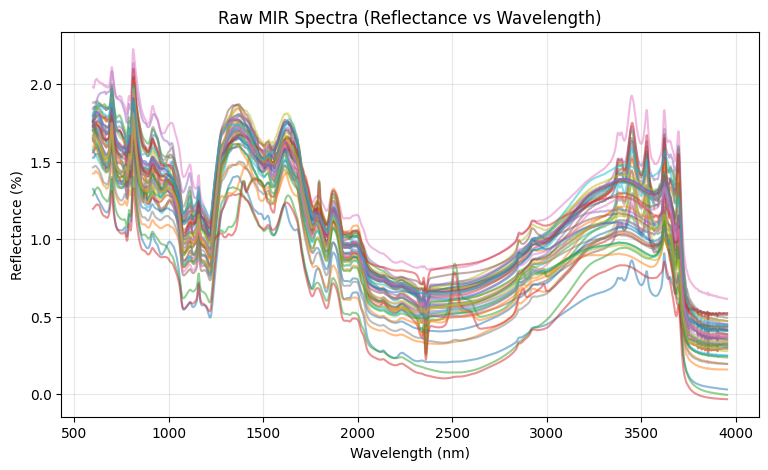

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Identify spectral columns (numeric names)
spec_cols = [c for c in df.columns if str(c).replace('.', '', 1).isdigit()]

# 2. Extract wavelengths and spectral matrix
wavelengths = np.array(spec_cols, dtype=float)
X = df[spec_cols].values.astype(float)

# 3. Plot up to 50 spectra
plt.figure(figsize=(9,5))
for i in range(min(50, X.shape[0])):   # plot up to 50 random samples
    plt.plot(wavelengths, X[i, :], alpha=0.5)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance (%)")
plt.title("Raw MIR Spectra (Reflectance vs Wavelength)")
plt.grid(alpha=0.3)
plt.show()


# ⚙️ Preprocessing — SNV + Savitzky–Golay filter

In [26]:

from scipy.signal import savgol_filter

def snv(X):
    return (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-12)

X_raw = df[spec_cols].to_numpy(float)
X_snv = snv(X_raw)
window = 11 if X_snv.shape[1] >= 21 else (X_snv.shape[1]//2*2+1)
X_sg = savgol_filter(X_snv, window_length=window, polyorder=2, deriv=1, axis=1)


# 📉 Plot Preprocessed Spectra

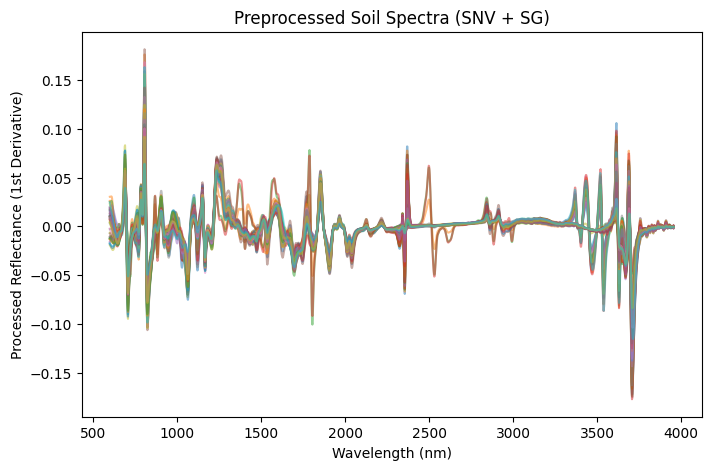

In [27]:

plt.figure(figsize=(8,5))
for i in range(min(50, len(df))):
    plt.plot(wavelengths, X_sg[i], alpha=0.5)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Processed Reflectance (1st Derivative)")
plt.title("Preprocessed Soil Spectra (SNV + SG)")
plt.show()


# 🔢 Split data and fit a simple PLSR model

In [32]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Drop rows where SOC is missing
df = df.dropna(subset=["eoc_tot_c"]).reset_index(drop=True)
print("After dropping null SOC rows:", df.shape)

# 2️⃣ Detect spectral columns again (from cleaned df)
spec_cols = [c for c in df.columns if str(c).replace('.', '', 1).isdigit()]

# 3️⃣ Extract spectra (X) and target (y)
X = df[spec_cols].values.astype(float)
y = df["eoc_tot_c"].values.astype(float)

# 4️⃣ Check they match
print("X shape:", X.shape)
print("y shape:", y.shape)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (important for PLS)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Fit PLSR model
pls = PLSRegression(n_components=10)  # you can tune n_components
pls.fit(X_train_s, y_train)

# Predictions
y_pred = pls.predict(X_test_s).ravel()

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² = {r2:.3f}")
print(f"RMSE = {rmse:.3f}")




After dropping null SOC rows: (109, 1744)
X shape: (109, 1740)
y shape: (109,)
R² = 0.920
RMSE = 0.388


# 📈 Scatter (Parity) Plot — Observed vs Predicted SOC

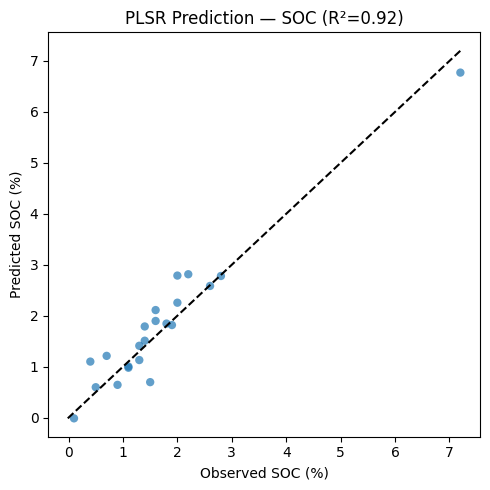

In [33]:

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='none')
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel("Observed SOC (%)")
plt.ylabel("Predicted SOC (%)")
plt.title(f"PLSR Prediction — SOC (R²={r2:.2f})")
plt.tight_layout()
plt.show()
